Locate phoneme positions which best separate candidate speech representations.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [32]:
from collections import Counter, defaultdict
import itertools
from pathlib import Path
import pickle
from typing import Any

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold
import torch
import transformers
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings

In [3]:
model_checkpoints = {
    "word_prefix": "out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600",
    "phoneme": "out/ce_model_phoneme_6_8/checkpoint-800/",
}

equiv_dataset_path = "data/timit_equiv_phoneme_1.pkl"
traj_path = "out/state_space_specs/all_phonemes_by_position.pkl"

In [6]:
models = {
    k: ContrastiveEmbeddingModel.from_pretrained(v)
    for k, v in model_checkpoints.items()
}

In [18]:
model_names = list(models.keys())

In [7]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset = pickle.load(f)

In [13]:
with open(traj_path, "rb") as f:
    traj_spec: StateSpaceAnalysisSpec = pickle.load(f)

In [14]:
assert traj_spec.is_compatible_with(equiv_dataset)

In [12]:
model_representations = {
    k: compute_embeddings(v, equiv_dataset, device="cpu").numpy()
    for k, v in tqdm(list(models.items()))
}

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4740 [00:00<?, ?it/s]

  0%|          | 0/4740 [00:00<?, ?it/s]

In [99]:
cv_folds = 10
cca_scores = np.zeros((len(traj_spec.labels), len(model_names), len(model_names), cv_folds))
cca_scores.fill(np.nan)

In [100]:
for i, phoneme_position in enumerate(tqdm(traj_spec.labels)):
    print(i)
    for model_j, model_k in itertools.product(list(range(len(model_names))), repeat=2):
        if model_j > model_k:
            continue
        spans = traj_spec.target_frame_spans[i]

        # TODO consider other agg fns
        rep_j = np.stack([model_representations[model_names[model_j]][start_frame:end_frame + 1].mean(0)
                          for start_frame, end_frame in spans])
        rep_k = np.stack([model_representations[model_names[model_k]][start_frame:end_frame + 1].mean(0)
                          for start_frame, end_frame in spans])

        assert rep_k.shape[0] == rep_j.shape[0]

        if rep_j.shape[0] < cv_folds * 2:
            continue

        cv = KFold(n_splits=cv_folds, shuffle=True)
        for fold, (train_idx, test_idx) in enumerate(cv.split(rep_j)):
            cca = CCA(n_components=min(rep_j.shape[1], rep_k.shape[1]))
            cca.fit(rep_j[train_idx], rep_k[train_idx])

            test_j_trans, test_k_trans = cca.transform(rep_j[test_idx], rep_k[test_idx])
            cca_scores[i, model_j, model_k, fold] = np.corrcoef(test_j_trans, test_k_trans)[0, 1]

  0%|          | 0/14 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [101]:
cca_scores_df = []
for i, model_i, model_j, fold in np.ndindex(*cca_scores.shape):
    cca_scores_df.append({
        "position": traj_spec.labels[i],
        "fold": fold,
        "model_i": model_names[model_i],
        "model_j": model_names[model_j],
        "cca_score": cca_scores[i, model_i, model_j, fold],
    })
cca_scores_df = pd.DataFrame(cca_scores_df).dropna()

In [102]:
cca_scores_df["comparison"] = cca_scores_df["model_i"] + " vs " + cca_scores_df["model_j"]

<Axes: xlabel='position', ylabel='cca_score'>

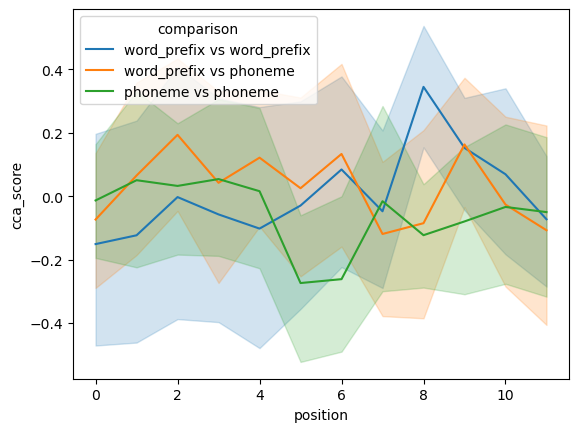

In [103]:
sns.lineplot(data=cca_scores_df, x="position", y="cca_score", hue="comparison")